In [2]:
# %pip install tensorflow
# %pip install scikit-lear+n pandas numpy
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import os 
import json
import requests
# %pip install matplotlib
import matplotlib.pyplot as plt
%pip install seaborn
from sklearn.metrics import confusion_matrix
import seaborn as sns


c:\Users\Laurent\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# --- CONFIG ---
# Update these paths if your folders are named differently
DATA_FOLDERS = [
    os.path.join('Data', 'parsed_matches_irons'),
    os.path.join('Data', 'parsed_matches') 
]
CHAMP_META_PATH = 'champ_data.csv'

# --- 1. FETCH ITEM DATA (So we can filter for Legendaries) ---
try:
    versions = requests.get("https://ddragon.leagueoflegends.com/api/versions.json").json()
    latest_version = versions[0]
    item_json = requests.get(f"https://ddragon.leagueoflegends.com/cdn/{latest_version}/data/en_US/item.json").json()
    
    # Create Lookup & Valid ID Set
    item_lookup = {int(k): v['name'] for k, v in item_json['data'].items()}
    VALID_LEGENDARY_IDS = set()
    
    for k, v in item_json['data'].items():
        item_id = int(k)
        depth = v.get('depth', 1)
        gold_total = v['gold']['total']
        
        # Rule: Depth >= 3 or Cost > 2000 (Filters out components)
        if depth >= 3 or gold_total > 2000:
            VALID_LEGENDARY_IDS.add(item_id)
            
    print(f"Loaded {len(VALID_LEGENDARY_IDS)} Legendary Items.")
except Exception as e:
    print(f"Error fetching items: {e}")
    item_lookup = {}
    VALID_LEGENDARY_IDS = set()

def get_item_name(item_id):
    return item_lookup.get(item_id, f"Item {item_id}")

Loaded 332 Legendary Items.


In [9]:
# --- CONFIG ---
# Update these paths if your folders are named differently
DATA_FOLDERS = [
    os.path.join('parsed_matches'),
]
CHAMP_META_PATH = 'champ_data.csv'

# --- 1. FETCH ITEM DATA (So we can filter for Legendaries) ---
try:
    versions = requests.get("https://ddragon.leagueoflegends.com/api/versions.json").json()
    latest_version = versions[0]
    item_json = requests.get(f"https://ddragon.leagueoflegends.com/cdn/{latest_version}/data/en_US/item.json").json()
    
    # Create Lookup & Valid ID Set
    item_lookup = {int(k): v['name'] for k, v in item_json['data'].items()}
    VALID_LEGENDARY_IDS = set()
    
    for k, v in item_json['data'].items():
        item_id = int(k)
        depth = v.get('depth', 1)
        gold_total = v['gold']['total']
        
        # Rule: Depth >= 3 or Cost > 2000 (Filters out components)
        if depth >= 3 or gold_total > 2000:
            VALID_LEGENDARY_IDS.add(item_id)
            
    print(f"Loaded {len(VALID_LEGENDARY_IDS)} Legendary Items.")
except Exception as e:
    print(f"Error fetching items: {e}")
    item_lookup = {}
    VALID_LEGENDARY_IDS = set()

def get_item_name(item_id):
    return item_lookup.get(item_id, f"Item {item_id}")

Loaded 332 Legendary Items.


In [10]:
champ_meta = pd.read_csv(CHAMP_META_PATH)
champ_dict = champ_meta.set_index('Champion').to_dict('index')

def get_legendary_sequence(purchase_list):
    """Returns only LEGENDARY item purchases in order."""
    sorted_events = sorted(purchase_list, key=lambda x: x['timestamp'])
    events = []
    for x in sorted_events:
        if x['type'] == 'ITEM_PURCHASED' and x['itemId'] in VALID_LEGENDARY_IDS:
            events.append((x['itemId'], x['timestamp']))
    return events

training_rows = []
raw_matches = []

print("Loading matches...")
for folder in DATA_FOLDERS:
    if not os.path.exists(folder): continue
    for filename in os.listdir(folder):
        if not filename.endswith('.json'): continue
        try:
            with open(os.path.join(folder, filename), 'r') as f:
                raw_matches.append(json.load(f))
        except: continue

print(f"Processing {len(raw_matches)} matches...")

for match_data in raw_matches:
    participants = match_data['participants']
    lane_map = {(p['teamId'], p['lane']): p for p in participants}
    
    for p in participants:
        if p['championName'] not in champ_dict: continue
        
        enemy_team = 200 if p['teamId'] == 100 else 100
        opponent = lane_map.get((enemy_team, p['lane']))
        
        if not opponent or opponent['championName'] not in champ_dict: continue
        
        # Get Sequence
        legendary_seq = get_legendary_sequence(p['item_purchases'])
        if len(legendary_seq) < 1: continue 
        
        current_inventory = []
        
        for item_id, timestamp in legendary_seq:
            training_rows.append({
                'my_champ': p['championName'],      # <--- KEY for Neural Net
                'enemy_champ': opponent['championName'], # <--- KEY for Neural Net
                'current_inventory': list(current_inventory),
                'target_item': item_id
            })
            current_inventory.append(item_id)

df = pd.DataFrame(training_rows)
print(f"Dataframe ready with {len(df)} samples.")

Loading matches...
Processing 6084 matches...
Dataframe ready with 178882 samples.


In [11]:
# A. Encode Champions (My Champ & Enemy)
# We combine both columns to ensure the encoder knows ALL champions
all_champs = pd.concat([df['my_champ'], df['enemy_champ']]).unique()
champ_encoder = LabelEncoder()
champ_encoder.fit(all_champs)

num_champs = len(all_champs)
print(f"Vocabulary Size: {num_champs} Champions")

# B. Encode Items (Target)
# We already filtered df to Top 50 / Legendary in previous steps
item_encoder = LabelEncoder()
y_raw = item_encoder.fit_transform(df['target_item'])
num_items = len(item_encoder.classes_)
print(f"Vocabulary Size: {num_items} Items")

# C. Prepare Inputs (X)
# 1. Champion IDs (Integers)
X_my_champ = champ_encoder.transform(df['my_champ'])
X_en_champ = champ_encoder.transform(df['enemy_champ'])

# 2. Inventory (Multi-Hot Vector)
# We turn the list of items [1001, 3078] into a static vector of 0s and 1s
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=item_encoder.classes_)
X_inventory = mlb.fit_transform(df['current_inventory'])

# D. Split Data
indices = np.arange(len(df))
X_train_idx, X_test_idx, y_train, y_test = train_test_split(indices, y_raw, test_size=0.2, random_state=42)

# Helper to slice the inputs based on split indices
def get_dataset(idx):
    return {
        'my_champ_in': X_my_champ[idx],
        'enemy_champ_in': X_en_champ[idx],
        'inventory_in': X_inventory[idx]
    }, y_train if idx is X_train_idx else y_test

X_train_dict, y_train_data = get_dataset(X_train_idx)
X_test_dict, y_test_data = get_dataset(X_test_idx)

Vocabulary Size: 171 Champions
Vocabulary Size: 105 Items


In [12]:
# --- Branch 1: My Champion ---
in_my_champ = Input(shape=(1,), name='my_champ_in')
# Embedding: Compress 160 champions into 8 dimensions (The "Style Vector")
emb_my_champ = Embedding(input_dim=num_champs, output_dim=8, name='my_champ_emb')(in_my_champ)
flat_my_champ = Flatten()(emb_my_champ)

# --- Branch 2: Enemy Champion ---
in_en_champ = Input(shape=(1,), name='enemy_champ_in')
emb_en_champ = Embedding(input_dim=num_champs, output_dim=8, name='enemy_champ_emb')(in_en_champ)
flat_en_champ = Flatten()(emb_en_champ)

# --- Branch 3: Current Inventory ---
in_inventory = Input(shape=(num_items,), name='inventory_in')
# We process inventory through a Dense layer to find combo patterns
dense_inv = Dense(16, activation='relu')(in_inventory)

# --- Merge ---
# Combine (My Style + Enemy Style + Current Items)
merged = Concatenate()([flat_my_champ, flat_en_champ, dense_inv])

# --- The Brain (Dense Layers) ---
x = Dense(64, activation='relu')(merged)
x = Dropout(0.3)(x) # Prevent overfitting on small data
x = Dense(32, activation='relu')(x)

# --- Output ---
# Softmax probability over all possible items
output = Dense(num_items, activation='softmax', name='output')(x)

model_nn = Model(inputs=[in_my_champ, in_en_champ, in_inventory], outputs=output)

# Compile
model_nn.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy', # Good for integer targets
                 metrics=['accuracy'])

model_nn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ my_champ_in         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enemy_champ_in      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ my_champ_emb        │ (None, 1, 8)      │      1,368 │ my_champ_in[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enemy_champ_emb     │ (None, 1, 8)      │      1,368 │ enemy_champ_in[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inventory_in        │ (None, 105)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8)         │          0 │ my_champ_emb[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8)         │          0 │ enemy_champ_emb[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │      1,696 │ inventory_in[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      2,112 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 105)       │      3,465 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,089 (47.22 KB)

 Trainable params: 12,089 (47.22 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Neural Nets need epochs.

history = model_nn.fit(
    X_train_dict, y_train_data,
    epochs=20,           # Iterate 20 times over the data
    batch_size=32,       # Update weights every 32 samples
    validation_split=0.1,
    verbose=1
)

Epoch 1/20
4025/4025 ━━━━━━━━━━━━━━━━━━━━ 4s 825us/step - accuracy: 0.2789 - loss: 2.7886 - val_accuracy: 0.3933 - val_loss: 2.1780
Epoch 2/20
4025/4025 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.3821 - loss: 2.2492 - val_accuracy: 0.4265 - val_loss: 2.0448
Epoch 3/20
4025/4025 ━━━━━━━━━━━━━━━━━━━━ 4s 957us/step - accuracy: 0.4032 - loss: 2.1558 - val_accuracy: 0.4475 - val_loss: 1.9710
Epoch 4/20
4025/4025 ━━━━━━━━━━━━━━━━━━━━ 4s 946us/step - accuracy: 0.4170 - loss: 2.0969 - val_accuracy: 0.4627 - val_loss: 1.9138
Epoch 5/20
4025/4025 ━━━━━━━━━━━━━━━━━━━━ 4s 951us/step - accuracy: 0.4248 - loss: 2.0622 - val_accuracy: 0.4601 - val_loss: 1.9012
Epoch 6/20
4025/4025 ━━━━━━━━━━━━━━━━━━━━ 4s 954us/step - accuracy: 0.4309 - loss: 2.0366 - val_accuracy: 0.4648 - val_loss: 1.8833
Epoch 7/20
4025/4025 ━━━━━━━━━━━━━━━━━━━━ 4s 950us/step - accuracy: 0.4317 - loss: 2.0205 - val_accuracy: 0.4704 - val_loss: 1.8661
Epoch 8/20
4025/4025 ━━━━━━━━━━━━━━━━━━━━ 4s 971us/step - accuracy: 0.4336 - l

In [14]:
# Keras built-in accuracy is Top-1. Let's calculate Top-3 manually.

preds_probs = model_nn.predict(X_test_dict)

def get_nn_top_k(probs, y_true, k=3):
    top_k_idx = np.argsort(probs, axis=1)[:, -k:]
    hits = 0
    for i, true_val in enumerate(y_true):
        if true_val in top_k_idx[i]:
            hits += 1
    return hits / len(y_true)

acc_1 = get_nn_top_k(preds_probs, y_test_data, k=1)
acc_3 = get_nn_top_k(preds_probs, y_test_data, k=3)

print(f"Neural Net Top-1 Acc: {acc_1:.1%}")
print(f"Neural Net Top-3 Acc: {acc_3:.1%}")

1119/1119 ━━━━━━━━━━━━━━━━━━━━ 1s 551us/step
Neural Net Top-1 Acc: 47.9%
Neural Net Top-3 Acc: 74.7%


In [15]:
# A function to query the Neural Network.

def recommend_nn(my_champ_name, enemy_champ_name, current_item_names):
    # 1. Encode Champions
    try:
        my_id = champ_encoder.transform([my_champ_name])
        en_id = champ_encoder.transform([enemy_champ_name])
    except ValueError:
        print("Error: Champion name not found in training data.")
        return

    # 2. Encode Inventory
    # Convert Names -> IDs -> Multi-Hot
    # We need to reverse map names to IDs first
    # (Assuming you have item_lookup from previous steps)
    inv_ids = []
    for name in current_item_names:
        # Simple search (can be optimized)
        for id, lookup_name in item_lookup.items():
            if name == lookup_name:
                inv_ids.append(id)
                break
    
    # Create the multi-hot vector
    # We must handle the case where items aren't in the Top 50 vocabulary
    valid_inv_ids = [i for i in inv_ids if i in item_encoder.classes_]
    inv_vector = mlb.transform([valid_inv_ids])

    # 3. Predict
    probs = model_nn.predict({
        'my_champ_in': my_id,
        'enemy_champ_in': en_id,
        'inventory_in': inv_vector
    }, verbose=0)[0]

    # 4. Decode
    top_3_idx = np.argsort(probs)[-3:][::-1]
    
    print(f"--- Neural Recommendation for {my_champ_name} vs {enemy_champ_name} ---")
    print(f"Owned: {current_item_names}")
    for idx in top_3_idx:
        item_id = item_encoder.inverse_transform([idx])[0]
        name = get_item_name(item_id)
        print(f"  {name}: {probs[idx]:.1%}")

# Test
recommend_nn("Yorick", "Aatrox", ["Trinity Force"])

--- Neural Recommendation for Yorick vs Aatrox ---
Owned: ['Trinity Force']
  Trinity Force: 75.8%
  Eclipse: 6.1%
  Spear of Shojin: 3.3%


# PLOTS & Analysis

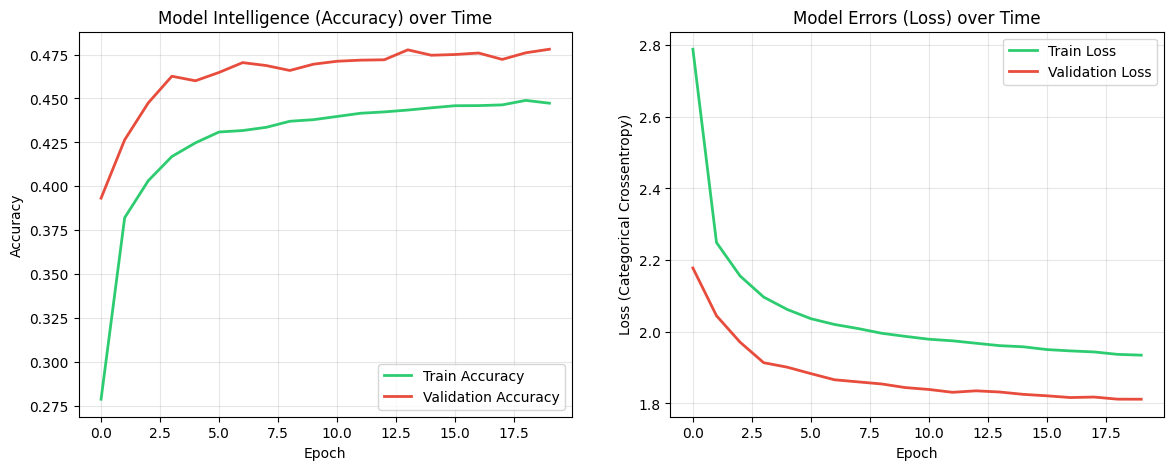

In [16]:


# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#2ecc71', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#e74c3c', linewidth=2)
plt.title('Model Intelligence (Accuracy) over Time')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Subplot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='#2ecc71', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='#e74c3c', linewidth=2)
plt.title('Model Errors (Loss) over Time')
plt.ylabel('Loss (Categorical Crossentropy)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.show()

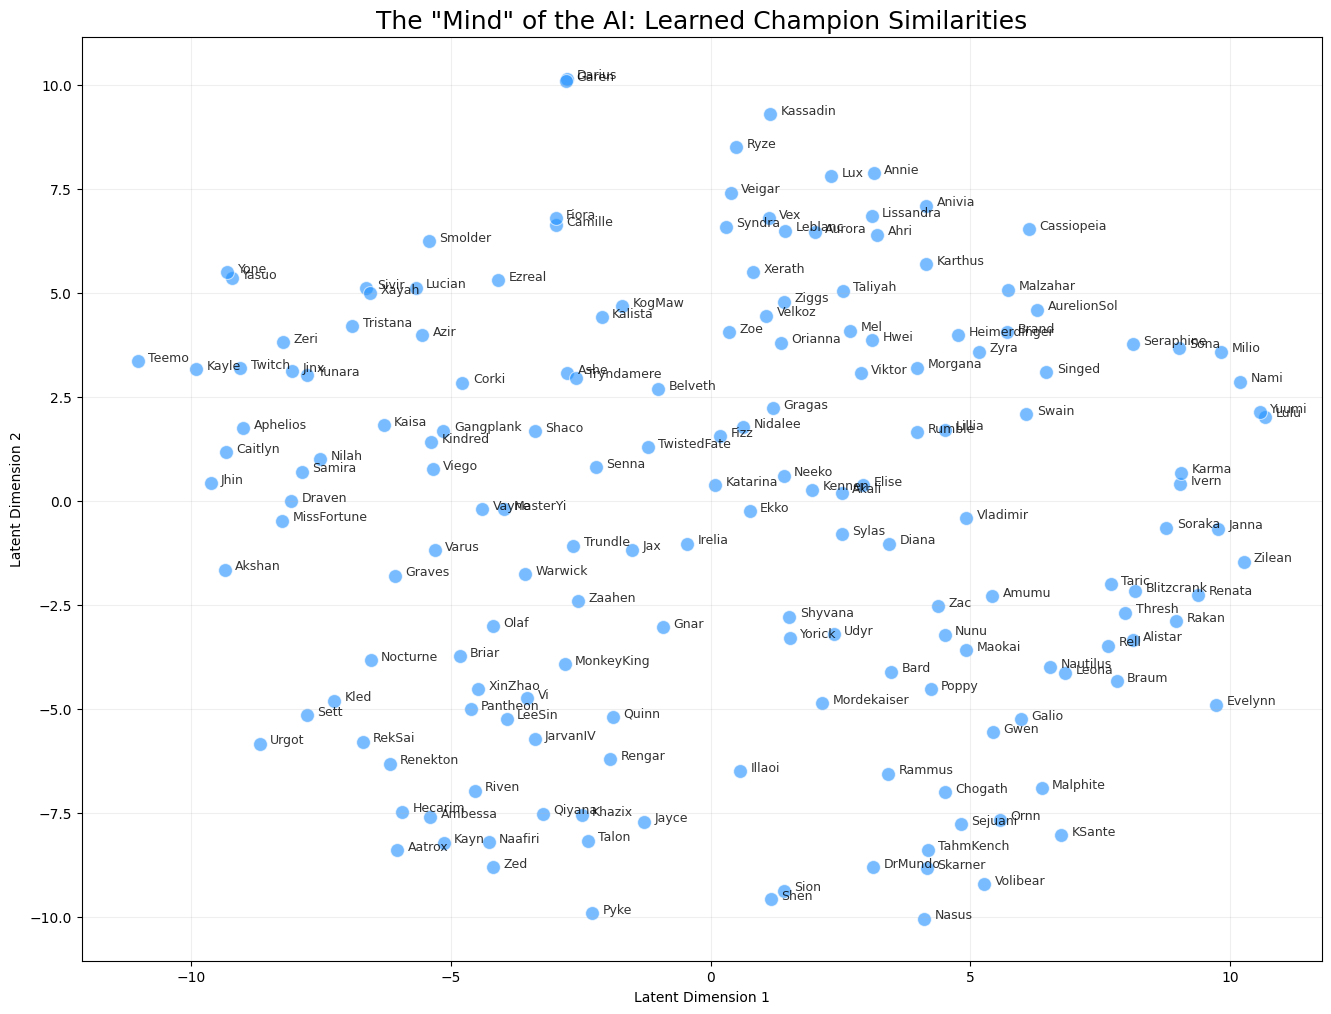

In [17]:
from sklearn.manifold import TSNE
import seaborn as sns

# 1. Get the learned weights from the "my_champ_emb" layer
champ_weights = model_nn.get_layer('my_champ_emb').get_weights()[0]

# 2. Reduce 8D -> 2D using t-SNE (Physics simulation)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(champ_weights)

# 3. Create a DataFrame for plotting
# We map IDs back to Names
champ_names = champ_encoder.classes_
emb_df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
emb_df['Champion'] = champ_names

# 4. Plot (Interactive-looking static plot)
plt.figure(figsize=(16, 12))
sns.scatterplot(data=emb_df, x='x', y='y', color='dodgerblue', alpha=0.6, s=100)

# Add text labels for popular champs (filtering to avoid clutter)
# You might want to label ALL of them or just a few specific ones
for i in range(len(emb_df)):
    # Optional: Only label every 2nd champion to avoid text mess, or specific ones
    if i % 1 == 0: 
        plt.text(emb_df.x[i]+0.2, emb_df.y[i], emb_df.Champion[i], fontsize=9, alpha=0.8)

plt.title('The "Mind" of the AI: Learned Champion Similarities', fontsize=18)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True, alpha=0.2)
plt.show()

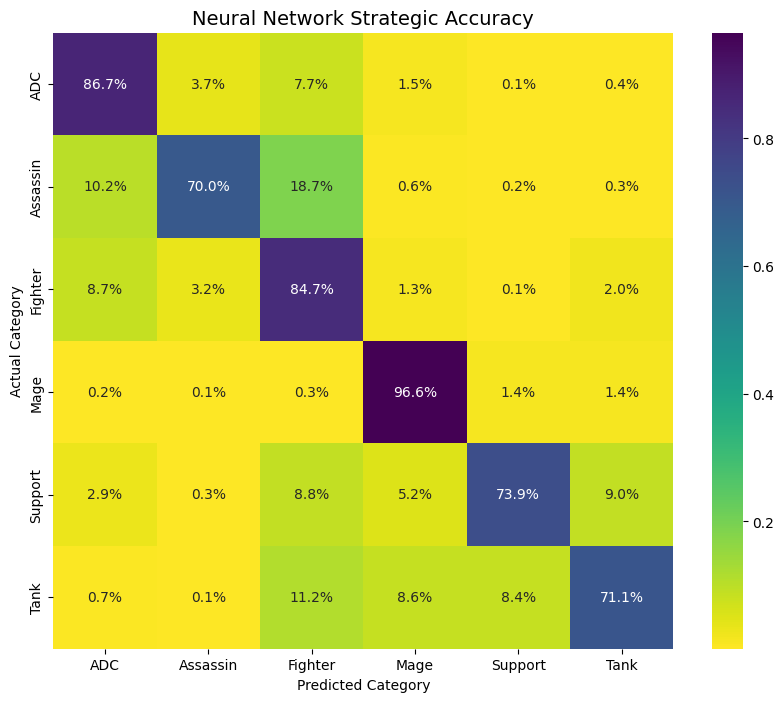

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. DEFINE ARCHETYPES ---
item_archetypes = {
    # --- FIGHTER ---
    3078: 'Fighter', 6630: 'Fighter', 6631: 'Fighter', 3071: 'Fighter', 
    6632: 'Fighter', 3053: 'Fighter', 6333: 'Fighter', 3074: 'Fighter', 
    3748: 'Fighter', 3161: 'Fighter', 6692: 'Fighter', 5565: 'Fighter', 
    3072: 'Fighter', 3153: 'Fighter',

    # --- TANK ---
    3068: 'Tank', 3065: 'Tank', 3075: 'Tank', 3001: 'Tank', 
    3111: 'Tank', 3047: 'Tank', 3110: 'Tank', 3025: 'Tank', 
    3083: 'Tank', 3084: 'Tank', 6665: 'Tank', 6667: 'Tank', 
    5587: 'Tank', 4401: 'Tank', 8001: 'Tank', 2502: 'Tank', 
    2504: 'Tank',

    # --- MAGE ---
    6653: 'Mage', 6655: 'Mage', 3089: 'Mage', 4645: 'Mage', 
    3157: 'Mage', 3100: 'Mage', 3102: 'Mage', 3165: 'Mage', 
    3116: 'Mage', 3135: 'Mage', 4646: 'Mage', 3118: 'Mage', 
    3003: 'Mage', 3027: 'Mage', 3115: 'Mage', 3152: 'Mage',

    # --- ADC ---
    6671: 'ADC', 3031: 'ADC', 3036: 'ADC', 3046: 'ADC', 
    3094: 'ADC', 3095: 'ADC', 6672: 'ADC', 3087: 'ADC', 
    3033: 'ADC', 6673: 'ADC', 3124: 'ADC', 3091: 'ADC', 
    3139: 'ADC',

    # --- ASSASSIN ---
    3142: 'Assassin', 6691: 'Assassin', 3179: 'Assassin', 3814: 'Assassin', 
    3134: 'Assassin', 6696: 'Assassin', 6695: 'Assassin', 6698: 'Assassin', 
    3156: 'Assassin', 6676: 'Assassin',

    # --- SUPPORT ---
    3190: 'Support', 3174: 'Support', 6617: 'Support', 2065: 'Support', 
    3504: 'Support', 3107: 'Support', 3222: 'Support', 3119: 'Support'
}

def get_archetype(item_id):
    return item_archetypes.get(item_id, 'Other')

# --- 2. GET PREDICTIONS ---
y_pred_probs_nn = model_nn.predict(X_test_dict, verbose=0)
y_pred_ids_nn = np.argmax(y_pred_probs_nn, axis=1)

# --- 3. MAP TO CLASSES ---
true_cats = [get_archetype(item_encoder.inverse_transform([y])[0]) for y in y_test_data]
pred_cats = [get_archetype(item_encoder.inverse_transform([y])[0]) for y in y_pred_ids_nn]

# --- 4. PLOT CONFUSION MATRIX (No 'Other') ---
# We explicitly define the labels we want to see. 
# Rows/Columns for 'Other' will be ignored automatically.
labels = ['ADC', 'Assassin', 'Fighter', 'Mage', 'Support', 'Tank']

cm = confusion_matrix(true_cats, pred_cats, labels=labels, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.1%', xticklabels=labels, yticklabels=labels, cmap='viridis_r')
plt.title('Neural Network Strategic Accuracy', fontsize=14)
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.show()

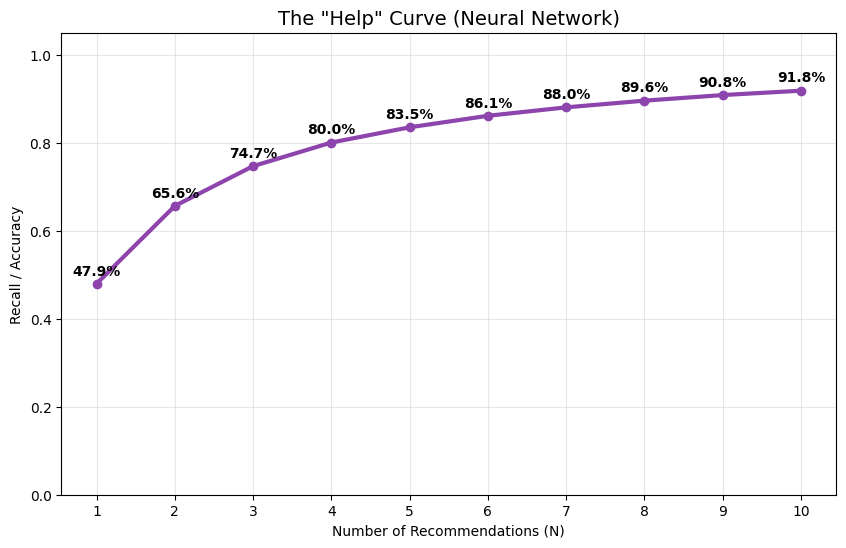

In [19]:
# Calculate Top-K Accuracy for K=1 to 10
k_values = range(1, 11)
accuracies = []

# Sort predictions once (High prob last)
sorted_indices = np.argsort(y_pred_probs_nn, axis=1)

for k in k_values:
    # Check if True Label is in the Top K predictions
    top_k = sorted_indices[:, -k:]
    hits = np.any(top_k == y_test_data[:, None], axis=1)
    accuracies.append(np.mean(hits))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linewidth=3, color='#8e44ad')

for k, acc in zip(k_values, accuracies):
    plt.text(k, acc + 0.02, f"{acc:.1%}", ha='center', fontweight='bold')

plt.title('The "Help" Curve (Neural Network)', fontsize=14)
plt.xlabel('Number of Recommendations (N)')
plt.ylabel('Recall / Accuracy')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05)
plt.xticks(k_values)
plt.show()

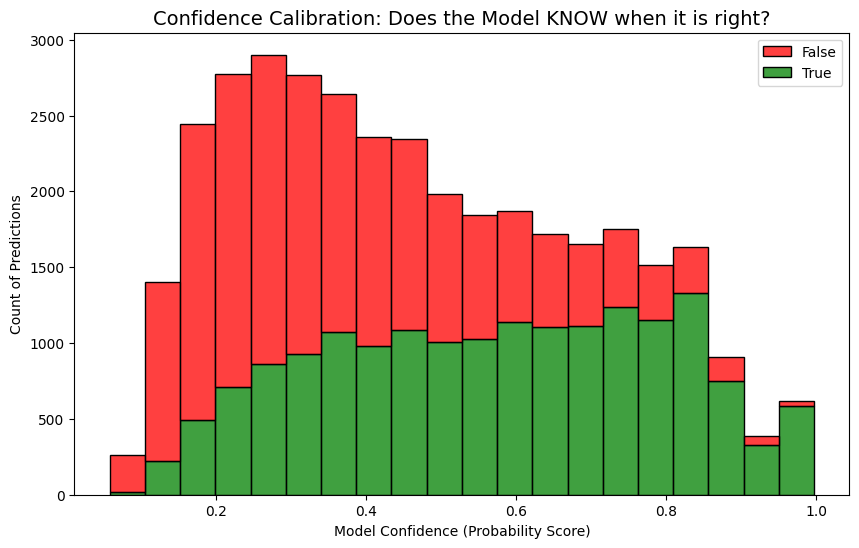

In [20]:
# Get the probability of the predicted item (Max Prob)
max_probs = np.max(y_pred_probs_nn, axis=1)
is_correct = (y_pred_ids_nn == y_test_data)

plt.figure(figsize=(10, 6))
sns.histplot(x=max_probs, hue=is_correct, bins=20, multiple="stack", palette={True: "green", False: "red"})
plt.title('Confidence Calibration: Does the Model KNOW when it is right?', fontsize=14)
plt.xlabel('Model Confidence (Probability Score)')
plt.ylabel('Count of Predictions')
plt.show()